In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
    
import sys  
sys.path.insert(0, '../src/')
from jsm_massfunc import CSMF, cumulative, CSMF_old, H2H_CSMF
from jsm_datareduc import prep_data
import galhalo


>>> Normalizing primordial power spectrum P(k)=(k/k_0)^n_s ...
    such that sigma(R=8Mpc/h) =   0.8000.
>>> Tabulating sigma(M,z=0) ...
    From now on, sigma(M,z) is computed by interpolation.
>>> Tabulating z(W) and z(t_lkbk)...
>>> Preparing output redshifts for merger trees ...
    Number of output redshifts =  354, up to z = 20.06
>>> Tabulating Parkinson+08 J(u_res) ...
>>> Building interpolation grid for Green+19 M(<r|f_b,c)...
>>> Building interpolation grid for Green+19 sigma(r|f_b,c)...
>>> Building interpolation grid for Green+19 d2Phidr2(r|f_b,c)...
>>> Building interpolator for Jiang+15 orbit sampler...


### reading in the accreation masses and redshifts for the surviving halos

In [4]:
Ms = prep_data("../../data/12_4_0/numpy/acc_surv_mass.npy")

### now to test the sampling
These next figures further motivate the point made lower down in the notebook

In [4]:
yuckave = []
yuckstd = []
for val in range(1,6):
    yuckave.append(np.average(np.random.normal(loc=7, scale=0.25, size=10**val)))
    yuckstd.append(np.std(np.random.normal(loc=7, scale=0.25, size=10**val)))

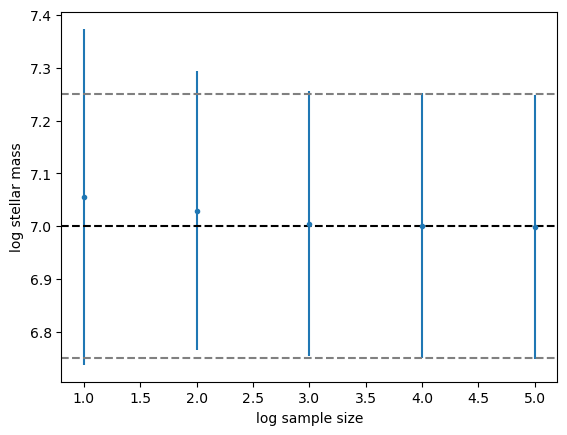

In [5]:
plt.errorbar(range(1,6), yuckave, yerr=yuckstd, fmt=".")
plt.axhline(7, color="black", ls="--")
plt.axhline(7.25, color="grey", ls="--")
plt.axhline(6.75, color="grey", ls="--")
plt.xlabel("log sample size")
plt.ylabel("log stellar mass")
plt.show()

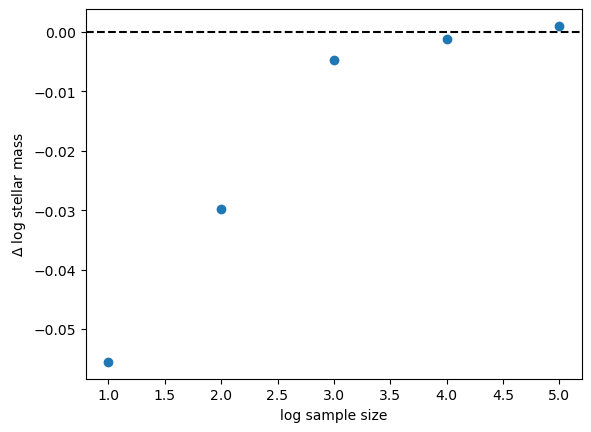

In [6]:
plt.scatter(range(1,6), 7-np.array(yuckave))
plt.axhline(0, color="black", ls="--")
plt.xlabel("log sample size")
plt.ylabel("$\Delta $ log stellar mass")
plt.show()
# roughly speaking 10^2 and 10^3 are accurate to ~1 percent
# less than 1 percent accuracy increase when going from 10^4 to 10^5

### so I think we are probably okay with a 1000 samples 
### that being said, that is roughly 10^8 values to store in memory while creating the matrix... 

In [5]:
scatter_pix = 25
scatter_range = np.round(np.linspace(0.0,1.5,scatter_pix), 3)
N_samples=500
N_iter=1000 # this will stop us from running into the memory issue

In [6]:
# #now to loop over each value of scatter, now to loop for every realization, and every subhalo!

# mat = np.zeros(shape=(scatter_pix,N_iter,Ms.shape[1],N_samples))

# for k, sigma in enumerate(scatter_range):

#     #print(k)

#     for i, pop in enumerate(Ms[0:N_iter]):

#         for j, subhalo in enumerate(pop):

#             mat[k, i, j] = np.random.normal(loc=subhalo, scale=sigma, size=N_samples)

In [7]:
#now lets save it so we dont have to run it again

#np.save("../../data/4D_shortest.npy", mat)

#mat = np.load("../../data/4D_short.npy")

In [8]:
mass_range = np.log10(np.logspace(3,10,50))

In [9]:
new_mat = np.zeros(shape=(scatter_pix,N_samples,3,50))

for k in range(scatter_pix):
    
    for n in range(N_samples):
  
        new_mat[k,n] = CSMF(mat[k,:,:,n], mass_range)

In [10]:
#np.save("../../data/4D_CSMF_shortest.npy", new_mat) # saving the data so I don't need to rerun it!
#new_mat = np.load("../../data/4D_CSMF_short.npy")
# the old version took almost twice as long!!

In [34]:
across_samp = np.average(new_mat, axis=1) # now lets look at the values!!

### now for the CSMF colored by scatter in the SHMR

In [35]:
norm = mpl.colors.Normalize(vmin=scatter_range.min(), vmax=scatter_range.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis)

colors = mpl.cm.viridis(np.linspace(0, 1, scatter_pix))

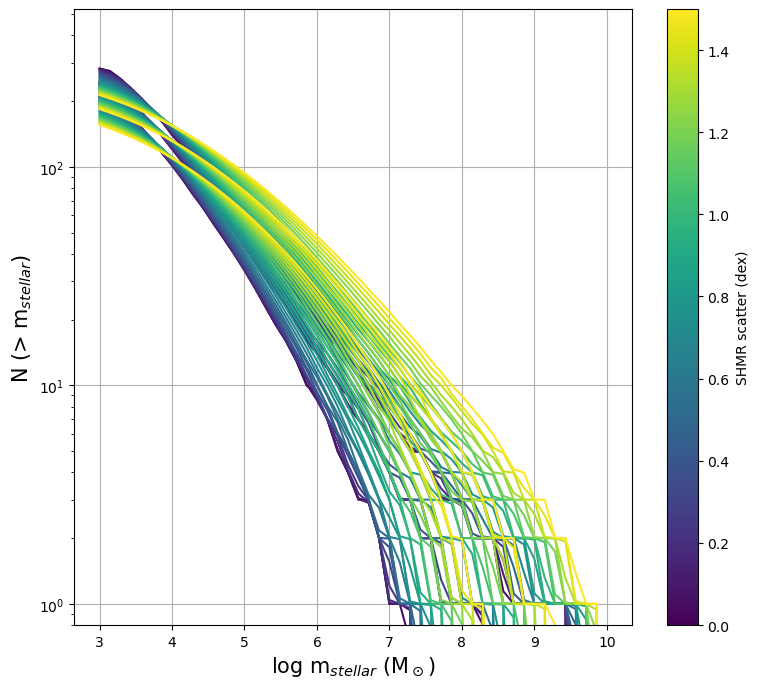

In [36]:
plt.figure(figsize=(9, 8)) # now plotting the color-coded CSMF!!

for i in range(scatter_pix):
    plt.plot(mass_range, across_samp[i][2], color=colors[i])
    plt.plot(mass_range, across_samp[i][1], color=colors[i])
    plt.plot(mass_range, across_samp[i][0], color=colors[i])


plt.yscale("log")
plt.grid()
plt.colorbar(cmap, label="SHMR scatter (dex)")
plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.ylabel("N (> m$_{stellar}$)", fontsize=15)
plt.ylim(0.8)
plt.show()

In [37]:
CSMF_mat = CSMF(Ms[0:N_iter], mass_range)

low = CSMF_mat[0]
median = CSMF_mat[1]
high = CSMF_mat[2]

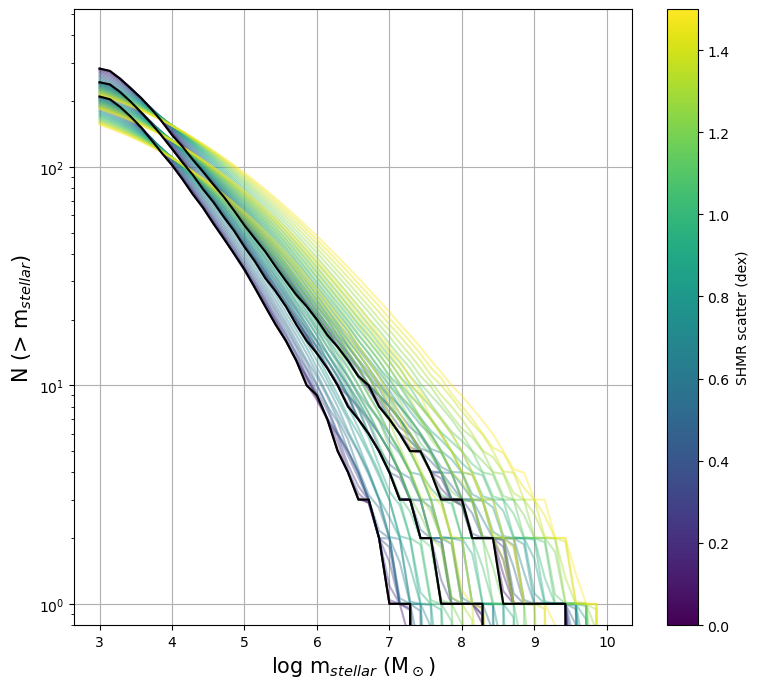

In [39]:
plt.figure(figsize=(9, 8)) # now plotting the color-coded CSMF!!

for i in range(scatter_pix):
    plt.plot(mass_range, across_samp[i][2], color=colors[i],alpha=0.4)
    plt.plot(mass_range, across_samp[i][1], color=colors[i],alpha=0.4)
    plt.plot(mass_range, across_samp[i][0], color=colors[i],alpha=0.4)

plt.plot(mass_range, low, color="black")
plt.plot(mass_range, median, color="black")
plt.plot(mass_range, high, color="black")


plt.yscale("log")
plt.grid()
plt.colorbar(cmap, label="SHMR scatter (dex)")
plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.ylabel("N (> m$_{stellar}$)", fontsize=15)
plt.ylim(0.8)
plt.savefig("../../figures/CSMF_with_det.png")
plt.show()

### now for the final figure!

In [41]:
stat = H2H_CSMF(across_samp)
det_stat = high-low

median = across_samp[:,1,:]
det_median = CSMF_mat[1]

In [42]:
mass_ind = [8,15,22,29,35]
masses = np.round(mass_range[mass_ind],0)
colors = ["maroon", "red", "orange", "green", "navy"]

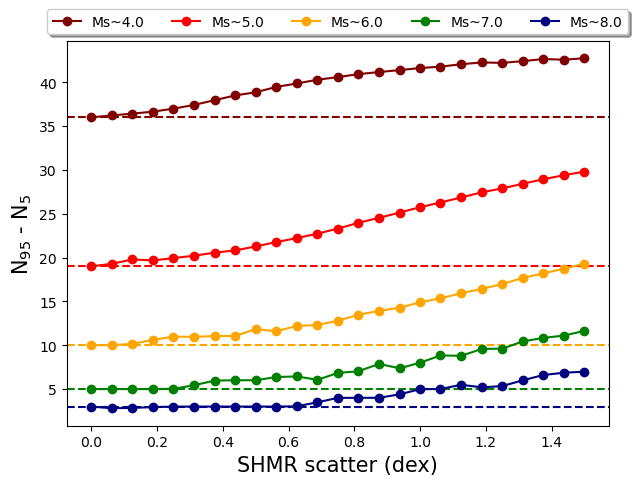

In [58]:
plt.figure(figsize=(7,5))

for i,val in enumerate(mass_ind):
    plt.plot(scatter_range, stat[:,val], label="Ms~"+str(masses[i]), color=colors[i],marker="o")
    plt.axhline(det_stat[val], ls="--", color=colors[i])

 
plt.xlabel("SHMR scatter (dex)", fontsize=15)
plt.ylabel("$\mathrm{N}_{95}$ - $\mathrm{N}_{5}$", fontsize=15)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=5, fancybox=True, shadow=True)
plt.savefig("../../figures/H2Hvar.png")
plt.show()

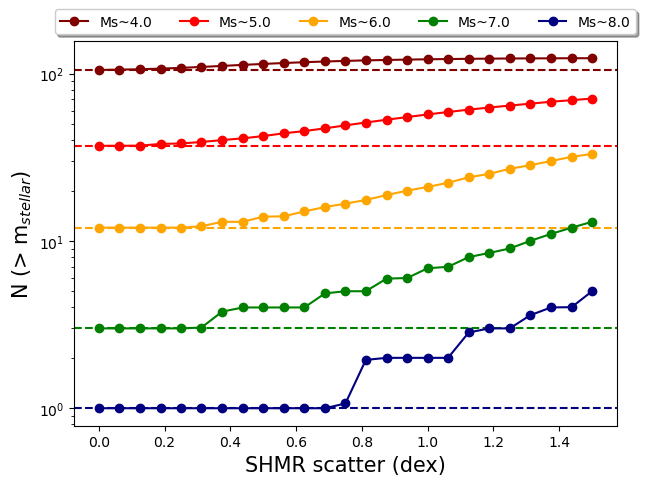

In [55]:
plt.figure(figsize=(7,5))

for i,val in enumerate(mass_ind):
    plt.plot(scatter_range, median[:,val], label="Ms~"+str(masses[i]), color=colors[i], marker="o")
    plt.axhline(det_median[val], ls="--", color=colors[i])

 
plt.xlabel("SHMR scatter (dex)", fontsize=15)
plt.ylabel("N (> m$_{stellar}$)", fontsize=15)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=5, fancybox=True, shadow=True)
plt.yscale("log")
plt.savefig("../../figures/CSMF_scatter.png")
plt.show()

### now for one merger tree

In [45]:
one_real = mat[:,90,:,:]

In [46]:
one_CSMF = np.zeros(shape=(scatter_pix,N_samples,50))

for k in range(scatter_pix):
    
    for n in range(N_samples):
  
        one_CSMF[k,n] = cumulative(one_real[k,:,n], mass_range)

In [47]:
across_samp_1D = np.average(one_CSMF,axis=1)

one_det = cumulative(Ms[90],mass_range)

In [48]:
norm = mpl.colors.Normalize(vmin=scatter_range.min(), vmax=scatter_range.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis)

colors = mpl.cm.viridis(np.linspace(0, 1, scatter_pix))

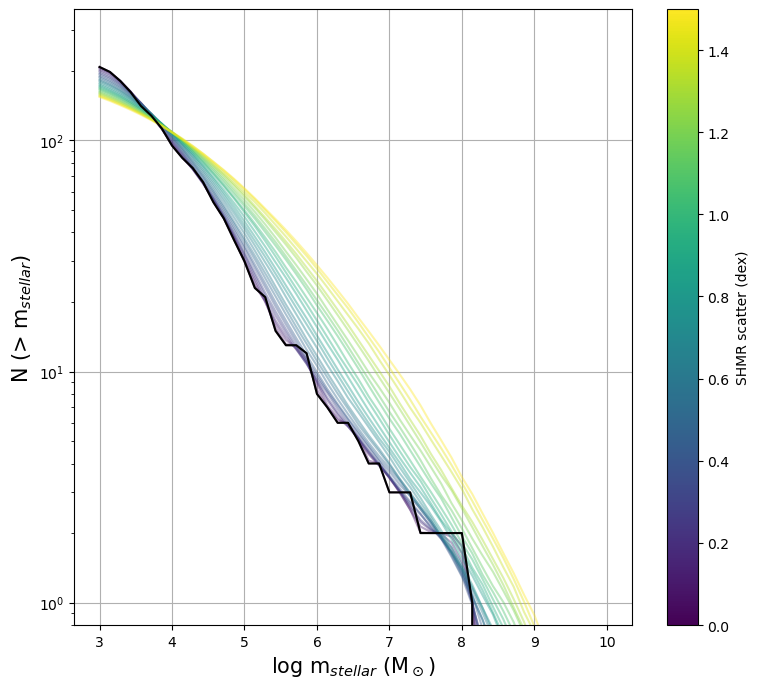

In [49]:
plt.figure(figsize=(9, 8)) # now plotting the color-coded CSMF!!

for i in range(scatter_pix):
    plt.plot(mass_range, across_samp_1D[i], color=colors[i], alpha=0.4)

plt.plot(mass_range, one_det, color="black")

plt.yscale("log")
plt.grid()
plt.colorbar(cmap, label="SHMR scatter (dex)")
plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.ylabel("N (> m$_{stellar}$)", fontsize=15)
plt.ylim(0.8)
plt.savefig("../../figures/single_CSMF_with_det.png")
plt.show()

In [50]:
one_det = cumulative(Ms[90],mass_range)
colors = ["maroon", "red", "orange", "green", "navy"]

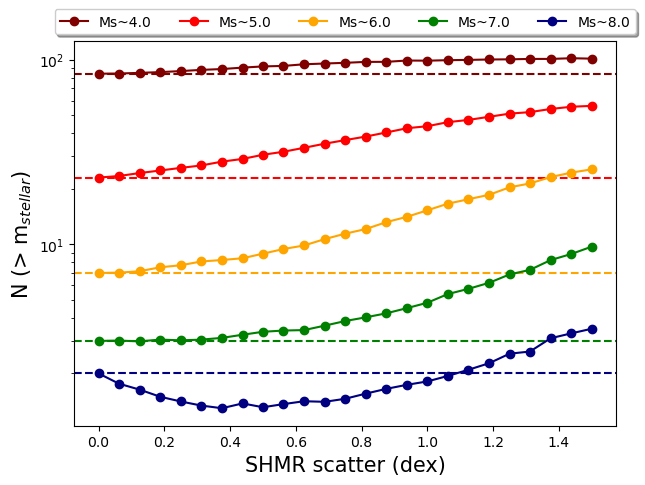

In [54]:
plt.figure(figsize=(7,5))

for i,val in enumerate(mass_ind):
    plt.plot(scatter_range, across_samp_1D[:,val], label="Ms~"+str(masses[i]), color=colors[i],marker="o")
    plt.axhline(one_det[val], ls="--", color=colors[i])

 
plt.xlabel("SHMR scatter (dex)", fontsize=15)
plt.ylabel("N (> m$_{stellar}$)", fontsize=15)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=5, fancybox=True, shadow=True)
plt.yscale("log")
plt.savefig("../../figures/single_CSMF_scatter.png")
plt.show()